В этом семинаре мы будем использовать наши знания путорча приобретенные неделю назад. Мы будем исследовать KL дивергенцию, поговорим про другие метрики, обусудим плюсы и минусы каждой. 

Также мы разберем несколько современных метрик для картиночных генеративных моделей

In [1]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
%matplotlib inline

import numpy as np


import torch
from torch import distributions as distrs
from torch.distributions.multivariate_normal import MultivariateNormal

from IPython.display import clear_output

Обозначим вспомогательные функции:

In [2]:
# Красиво рисует двумерное распределение
def plot_2d_dots(dots, color='blue', label='None'):
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.scatter(dots[:, 0], dots[:, 1], s=1, c=color, label=label)

def create_distr(mu, sigma):
    return distrs.MultivariateNormal(mu, sigma)

# Оборачивает параметры распределения в торчевские тензоры
def get_parameters(mu=0., sigma=1.):
    train_mu = torch.Tensor([mu, mu])
    train_mu.requires_grad=True
    train_sigma = torch.Tensor([[sigma, 0.0],
                                [0.0, sigma]])
    train_sigma.requires_grad=True
    return train_mu, train_sigma

def sample(d, num):
    return d.sample(torch.Size([num]))

# Глава 1, в которой студенты работают с унимодальным 2D распределением

##### Target distribution

In [3]:
mu = torch.Tensor([-5, -5])
sigma = torch.Tensor([[1., 0.0],
                      [0.0, 1.]])

target = create_distr(mu, sigma)
# x - samples from the target distribution
x = sample(target, 1000)
# px = p(x) = probability of target samples for the target distribution
px = target.log_prob(x).exp()

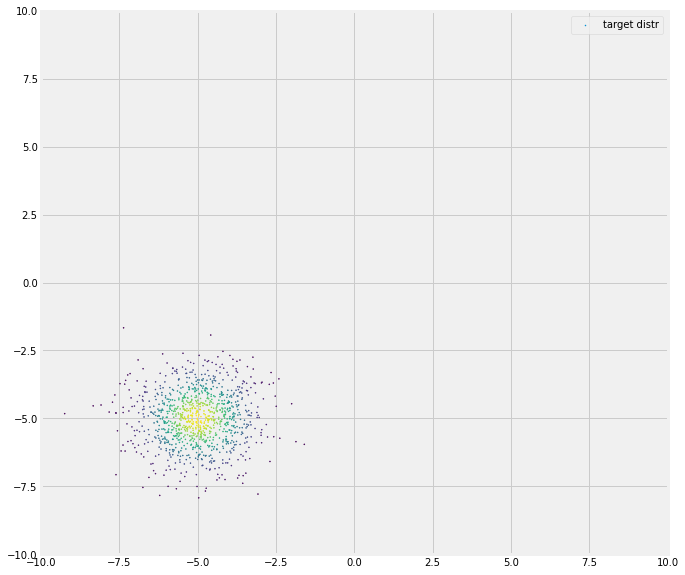

In [4]:
plt.figure(figsize=(10, 10))
plot_2d_dots(x, color=px, label='target distr')
plt.legend()
plt.show()

### Our approximation to the target distribution

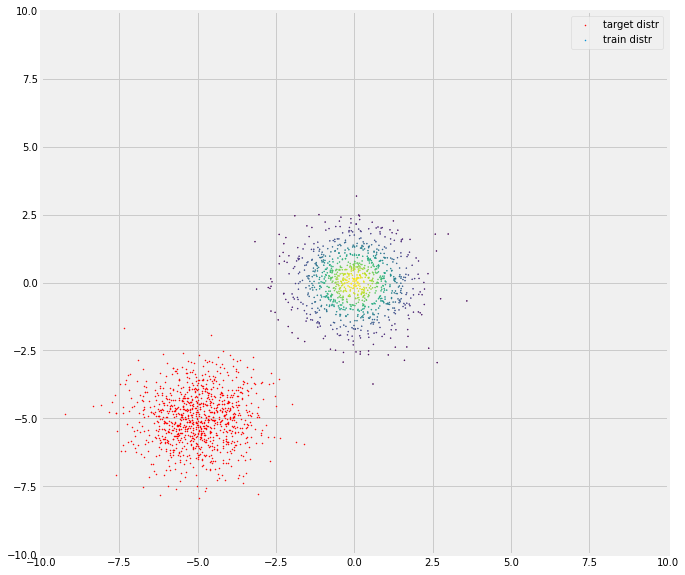

In [5]:
# starting points
train_mu, train_sigma = get_parameters()

Q = create_distr(train_mu, train_sigma)
q_sample = sample(Q, 1000)
plt.figure(figsize=(10, 10))
plot_2d_dots(x, color='r', label='target distr')
plot_2d_dots(q_sample, color= Q.log_prob(q_sample).exp().detach(), label='train distr')

plt.legend()
plt.show()

In [6]:
def kl_loss(qx, px):
    # Clamp for the numerical stability 
    px, qx = px.clamp(min=1e-7), qx.clamp(min=1e-7)
    return torch.mean(px * (px.log() - qx.log())) # YOUR CODE

# train_mu and train_sigma are TRAINABLE parameters
train_mu, train_sigma = get_parameters()

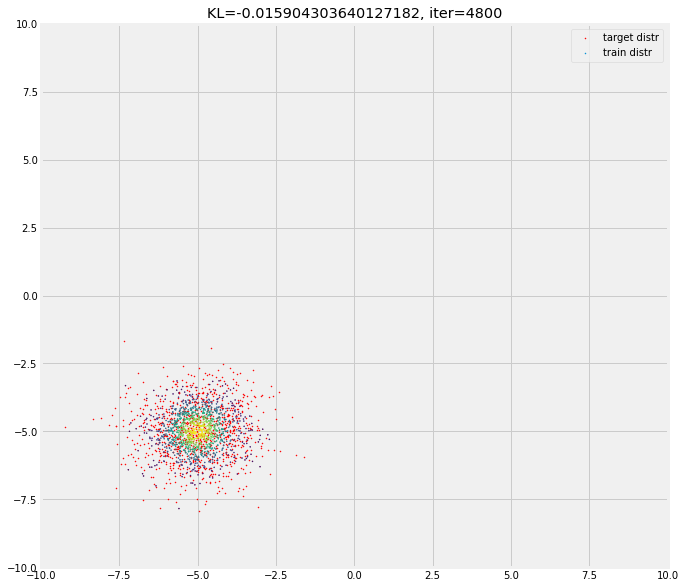

In [7]:
# Try replacing SGD with Adam
optim = torch.optim.SGD([train_mu, train_sigma], lr=0.1)

for i in range(5000):
    optim.zero_grad()
    Q = create_distr(train_mu, train_sigma)
    # qx = q(x) = probability of target samples for the train distribution
    qx = Q.log_prob(x).exp()
    loss = kl_loss(qx, px)
    loss.backward()
    optim.step()
    if i % 200 == 0:
        # plot pdfs
        clear_output(True)
        plt.figure(figsize=(10, 10))
        plt.title(f'KL={loss.item()}, iter={i}')
        plot_2d_dots(x, color='r', label='target distr')
        # q_sample - samples from the train distribution, just for visualization
        q_sample = sample(Q, 1000)
        plot_2d_dots(q_sample, color= Q.log_prob(q_sample).exp().detach(), label='train distr')
        plt.legend()
        plt.show()

# Глава 2, в которой студенты работают с 2D бимодальным распределением и узнают что KL дивергениция работает не так как нужно

### Target distr

In [8]:
target1 = create_distr(torch.Tensor([-5, -5]), torch.Tensor([[1., 0.0], [0.0, 1.]]))
target2 = create_distr(torch.Tensor([4, 3]), torch.Tensor([[1., 0.0], [0.0, 1.]]))

x = torch.cat([sample(target1, 1000), sample(target2, 1000)])

px = target1.log_prob(x).exp() + target2.log_prob(x).exp()

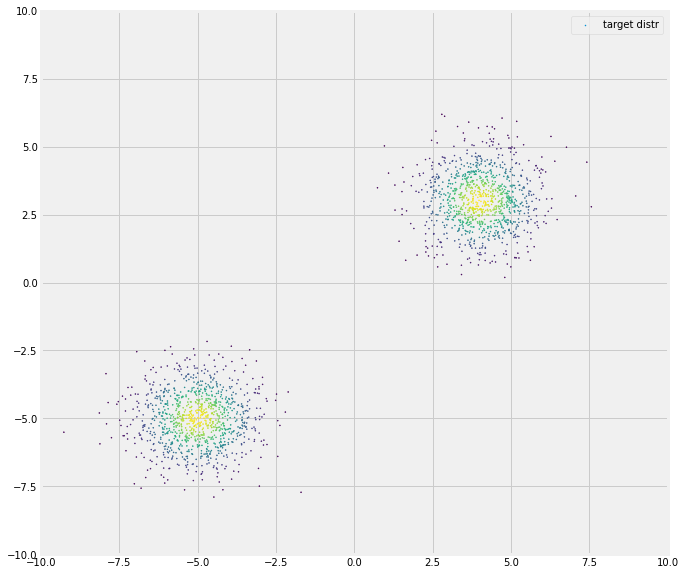

In [9]:
plt.figure(figsize=(10, 10))
plot_2d_dots(x, color=px, label='target distr')
plt.legend()
plt.show()

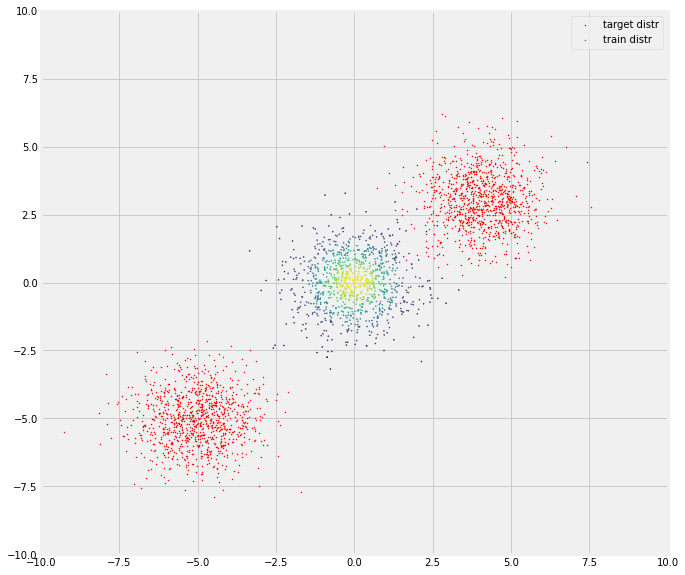

In [10]:
train_mu, train_sigma = get_parameters()

Q = create_distr(train_mu, train_sigma)
q_sample = sample(Q, 1000)
plt.figure(figsize=(10, 10))
plot_2d_dots(x, color='r', label='target distr')
plot_2d_dots(q_sample, color= Q.log_prob(q_sample).exp().detach(), label='train distr')

plt.legend()
plt.show()

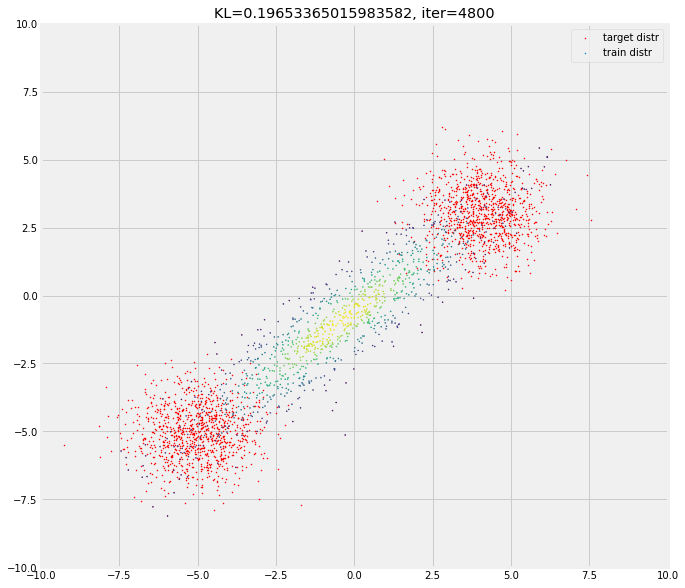

In [11]:
optim = torch.optim.SGD([train_mu, train_sigma], lr=0.1)

for i in range(5000):
    optim.zero_grad()
    Q = create_distr(train_mu, train_sigma)
    qx = Q.log_prob(x).exp()
    loss = kl_loss(qx, px)
    loss.backward()
    optim.step()
    if i % 200 == 0:
        # plot pdfs
        clear_output(True)
        plt.figure(figsize=(10, 10))
        plt.title(f'KL={loss.item()}, iter={i}')
        plot_2d_dots(x, color='r', label='target distr')
        q_sample = sample(Q, 1000)
        plot_2d_dots(q_sample, color= Q.log_prob(q_sample).exp().detach(), label='train distr')
        plt.legend()
        plt.show()

# Глава 3, в которой студенты узнают что можно взять лучшее из обоих миров

#### Jensen–Shannon divergence

In [12]:
def js_div(qx, px):
    return 0.5 * kl_loss(px, 0.5*px+0.5*qx) + 0.5 * kl_loss(qx, 0.5*px+0.5*qx) # YOUR CODE

In [13]:
train_mu, train_sigma = get_parameters(1, 1)

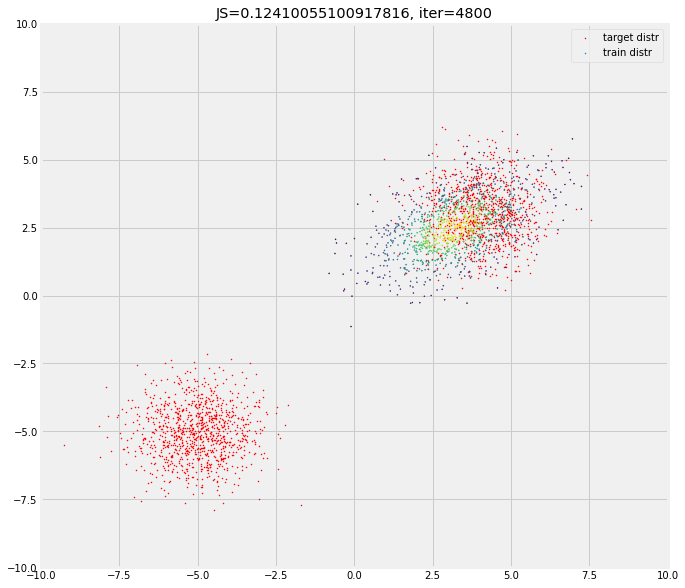

In [14]:
optim = torch.optim.SGD([train_mu, train_sigma], lr=0.1)

for i in range(5000):
    optim.zero_grad()
    Q = create_distr(train_mu, train_sigma)
    qx = Q.log_prob(x).exp()
    loss = js_div(qx, px)
    loss.backward()
    optim.step()
    if i % 200 == 0:
        # plot pdfs
        clear_output(True)
        plt.figure(figsize=(10, 10))
        plt.title(f'JS={loss.item()}, iter={i}')
        plot_2d_dots(x, color='r', label='target distr')
        q_sample = sample(Q, 1000)
        plot_2d_dots(q_sample, color= Q.log_prob(q_sample).exp().detach(), label='train distr')
        plt.legend()
        plt.show()

# Глава 5, в которой студенты смотрят на другой LSE 

### Least Squares  
*as in [here](https://www.arxiv-vanity.com/papers/1611.04076/)

In [15]:
def LSE_loss(qx, px):
    return torch.nn.MSELoss()(qx, px) # YOUR CODE

In [16]:
train_mu, train_sigma = get_parameters(1, 1)

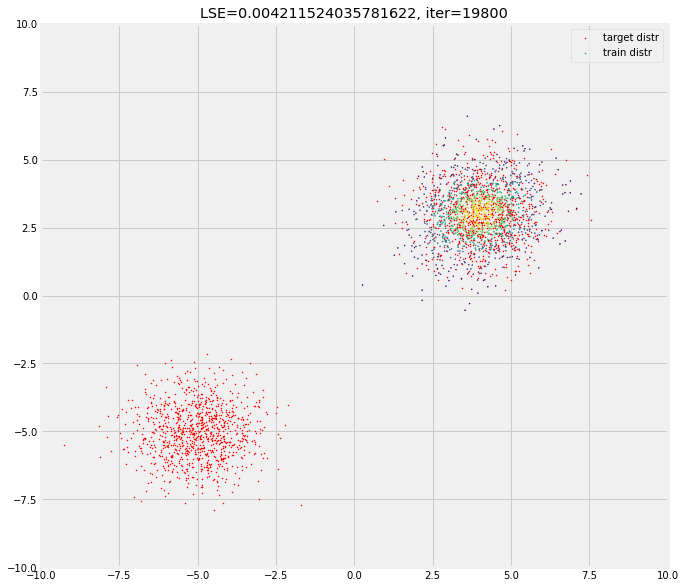

In [17]:
optim = torch.optim.SGD([train_mu, train_sigma], lr=0.5)

for i in range(20000):
    optim.zero_grad()
    Q = create_distr(train_mu, train_sigma)
    qx = Q.log_prob(x).exp()
    loss = LSE_loss(qx, px)
    loss.backward()
    optim.step()
    if i % 200 == 0:
        # plot pdfs
        clear_output(True)
        plt.figure(figsize=(10, 10))
        plt.title(f'LSE={loss.item()}, iter={i}')
        plot_2d_dots(x, color='r', label='target distr')
        q_sample = sample(Q, 1000)
        plot_2d_dots(q_sample, color= Q.log_prob(q_sample).exp().detach(), label='train distr')
        plt.legend()
        plt.show()

### Additional глава, в которой показывается что на KL и JS, на 1D бимодальных распределениях градиенты затухают


In [26]:
mu1, sigma1 = -3, 0.5
mu2, sigma2 = -8, 0.5


target1 = distrs.Normal(mu1, sigma1)
target2 = distrs.Normal(mu2, sigma2)

x = torch.linspace(-10, 10, 1000)
px = target1.log_prob(x).exp() + target2.log_prob(x).exp()

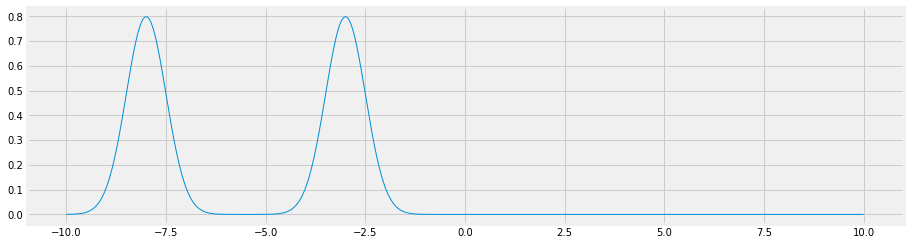

In [27]:
plt.figure(figsize=(14,4))

plt.plot(x.numpy(), px.numpy(), linewidth=1)
plt.show()


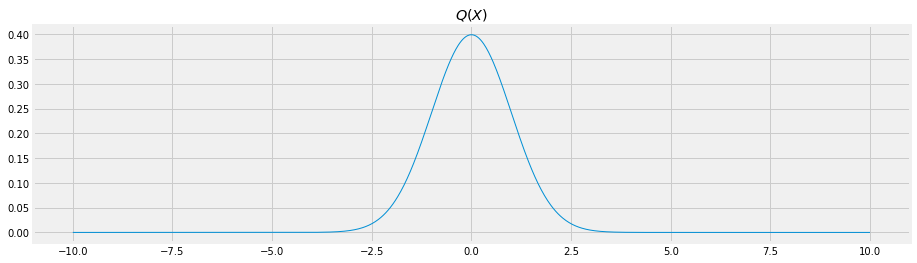

In [28]:
train_mu = torch.Tensor([0.0])
train_mu.requires_grad=True
train_sigma = torch.Tensor([1.0])
train_sigma.requires_grad=True

plt.figure(figsize=(14,4))
Q = distrs.Normal(train_mu, train_sigma)
qx = Q.log_prob(x).exp()
plt.plot(x.numpy(), qx.detach().numpy(), linewidth=1)
plt.title('$Q(X)$')
plt.show()

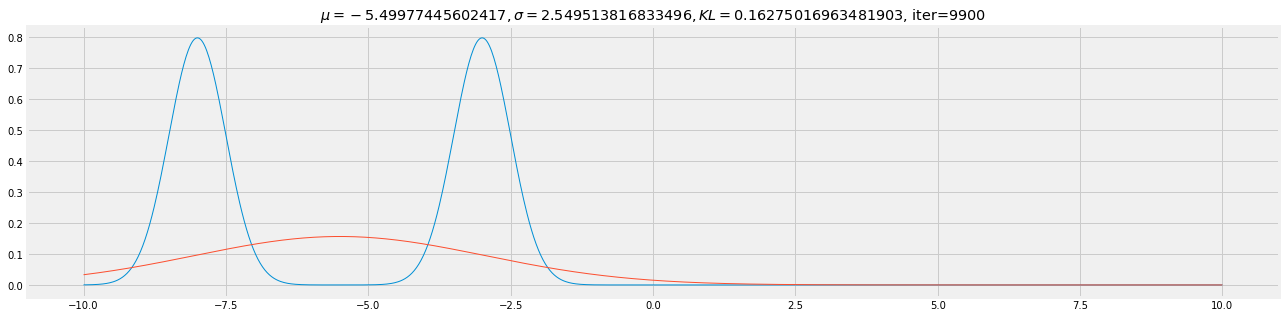

In [29]:
optim = torch.optim.SGD([train_mu, train_sigma], lr=0.1)
grads_mu = []
grads_sigma = []

for i in range(10000):
    optim.zero_grad()
    Q = distrs.Normal(train_mu, train_sigma)
    qx = Q.log_prob(x).exp()
    loss = kl_loss(qx, px)
    loss.backward()
    grads_mu.append(np.abs(train_mu.grad.item()))
    grads_sigma.append(np.abs(train_sigma.grad.item()))
    optim.step()
    if i % 300 == 0:
        # plot pdfs
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.title(f'$\mu={train_mu.item()}, \sigma={train_sigma.item()}, KL={loss.item()}$, iter={i}')
        plt.plot(x.numpy(), px.numpy(), linewidth=1)
        plt.plot(x.numpy(), qx.detach().numpy(), linewidth=1)
        plt.show()

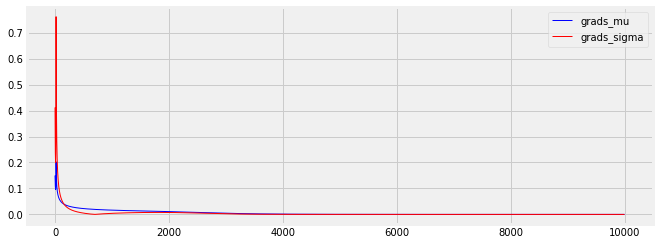

In [30]:
plt.figure(figsize=(10, 4))
plt.plot(grads_mu, c='blue', linewidth=1, label = 'grads_mu')
plt.plot(grads_sigma, c='red', linewidth=1, label = 'grads_sigma')
plt.legend()
plt.show()

###### JS

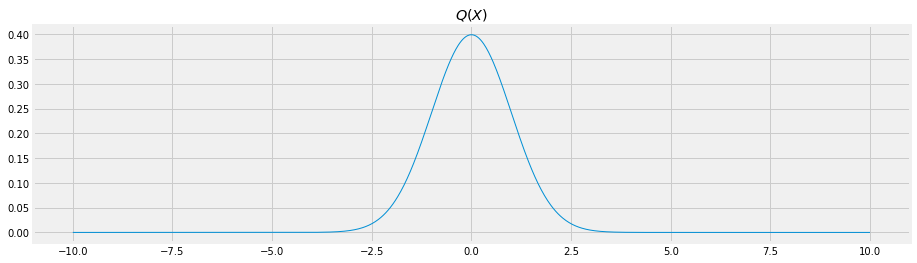

In [31]:
train_mu = torch.Tensor([0.0])
train_mu.requires_grad=True
train_sigma = torch.Tensor([1.0])
train_sigma.requires_grad=True

plt.figure(figsize=(14,4))
Q = distrs.Normal(train_mu, train_sigma)
qx = Q.log_prob(x).exp()
plt.plot(x.numpy(), qx.detach().numpy(), linewidth=1)
plt.title('$Q(X)$')
plt.show()

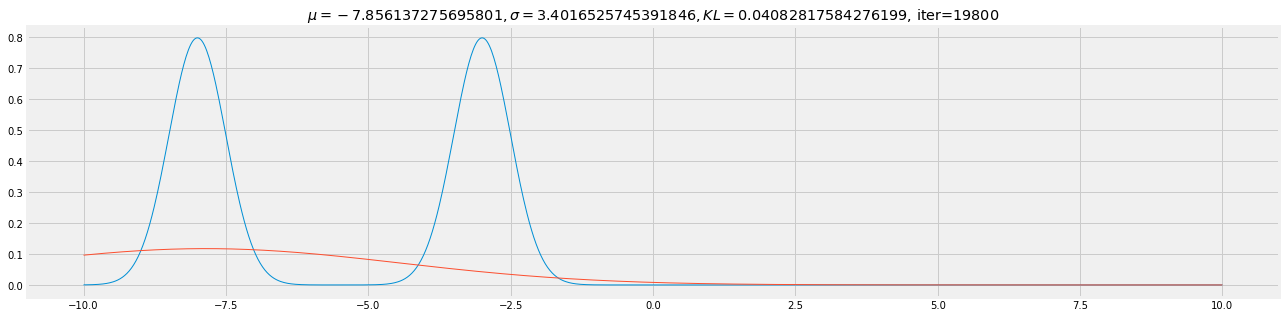

In [32]:
optim = torch.optim.SGD([train_mu, train_sigma], lr=0.5)
grads_mu = []
grads_sigma = []

for i in range(20000):
    optim.zero_grad()
    Q = distrs.Normal(train_mu, train_sigma)
    qx = Q.log_prob(x).exp()
    loss = js_div(qx, px)
    loss.backward()
    grads_mu.append(np.abs(train_mu.grad.item()))
    grads_sigma.append(np.abs(train_sigma.grad.item()))
    optim.step()
    if i % 300 == 0:
        # plot pdfs
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.title(f'$\mu={train_mu.item()}, \sigma={train_sigma.item()}, KL={loss.item()}$, iter={i}')
        plt.plot(x.numpy(), px.numpy(), linewidth=1)
        plt.plot(x.numpy(), qx.detach().numpy(), linewidth=1)
        plt.show()

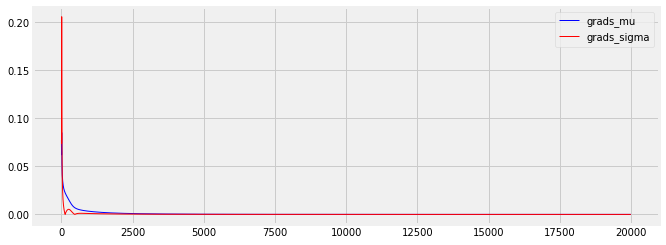

In [33]:
plt.figure(figsize=(10, 4))
plt.plot(grads_mu, c='blue', linewidth=1, label = 'grads_mu')
plt.plot(grads_sigma, c='red', linewidth=1, label = 'grads_sigma')
plt.legend()
plt.show()